In [1]:
# accumumate all headlines over a series of days based off a list of media organisation you want to include and start dates
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from mediadata import get_headline_df, get_biden_trump_dataframes, get_accumulated_headlines
from tf_idf import remove_stopwords, build_documents, get_tf_idf_df

start_date = datetime.date(2024, 3, 1)
end_date = datetime.date(2024, 4, 1)
media_orgs = ['FOX', 'NBC']

# df = get_accumulated_headlines(start_date, end_date, media_orgs)
# df_no_stopwords = remove_stopwords(df)

C:\Users\Danie\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Danie\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
df_no_stopwords

,Headline,MediaOrg
0,NASA unlocks new sounds universe project trans...,FOX
1,"UK-owned ship struck Houthis sinks, first vess...",FOX
2,"Andy Kennedy Goes Berserk, Gets Tossed After U...",FOX
3,Archaeologists uncover strange hoard ancient s...,FOX
4,‘I don’t sleep’: Violent crime surge pushed bu...,FOX
...,...,...
162,Military clears Ospreys fly series fatal crashes,NBC
163,6 key takeways Biden's fiery election year Sta...,NBC
164,Patrick Mahomes' younger brother sentenced cas...,NBC
165,Doctors call attention 'margarita rashes' sun ...,NBC


In [9]:
from nltk import FreqDist
from itertools import combinations
from collections import Counter

def generate_co_occurrence_matrix(headlines):
    # Create a list of all words in all headlines
    words = [word for headline in headlines for word in headline.split()]

    # Get a list of all unique words
    vocab = list(set(words))

    # Create a dictionary where we will store the co-occurrence frequencies
    co_occurrence_dict = Counter()

    # For each headline, get all unique pairs of words and update their count in the dictionary
    for headline in headlines:
        unique_pairs = list(combinations(set(headline.split()), 2))
        co_occurrence_dict.update(unique_pairs)

    # Create an empty co-occurrence matrix
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))

    # Fill the co-occurrence matrix using the frequencies from the dictionary
    for pair, freq in co_occurrence_dict.items():
        index_word1 = vocab.index(pair[0])
        index_word2 = vocab.index(pair[1])
        co_occurrence_matrix[index_word1][index_word2] = freq
        co_occurrence_matrix[index_word2][index_word1] = freq  # because it's a symmetric matrix

    # Convert the matrix to a DataFrame for better readability
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=vocab, columns=vocab)

    return co_occurrence_df


# nbc_df = df_no_stopwords[df_no_stopwords['MediaOrg'] == 'NBC']
# fox_df = df_no_stopwords[df_no_stopwords['MediaOrg'] == 'FOX']
# nbc_co_occurence = generate_co_occurrence_matrix(nbc_df['Headline'])
# fox_co_occurence = generate_co_occurrence_matrix(fox_df['Headline'])

In [5]:
nbc_co = nbc_co_occurence[['Biden', 'Trump']]
fox_co = fox_co_occurence[['Biden', 'Trump']]

In [10]:
biden_

water          0.0
rights         2.0
nomination     0.0
fitness        2.0
remarks        0.0
              ... 
money          0.0
Union         26.0
Adams'         0.0
winter         0.0
Congress       4.0
Name: Biden, Length: 3095, dtype: float64

In [12]:
# nbc_biden = dict(nbc_co.sort_values('Biden', ascending=False)['Biden'].head(20))
# nbc_trump = dict(nbc_co.sort_values('Trump', ascending=False)['Trump'].head(20))
# fox_biden = dict(fox_co.sort_values('Biden', ascending=False)['Biden'].head(20))
# fox_trump = dict(fox_co.sort_values('Trump', ascending=False)['Trump'].head(20))
from typing import List

def get_accumulated_headlines(start_date: datetime.date, end_date: datetime.date, media_orgs: List[str]):
    """Gets a dataframe of headlines for multiple media organisations over multiple dates"""

    headlines = []

    for media_org in media_orgs:

        current = start_date

        while current < end_date:
            try:
                df = get_headline_df(media_org, current)
                df['MediaOrg'] = [media_org]*len(df)
                headlines.append(df)
            except:
                pass

            current += datetime.timedelta(1)

    if len(headlines) == 0:
        return pd.DataFrame()
    
    return pd.concat(headlines)

def generate_similarity_score(org1: dict, org2: dict):
    """Creates the similarity score between two corpora (based off word counts)"""
    total = sum(org1.values()) + sum(org2.values())
    running_total = 0
    for key, value in org1.items():
        if key in org2:
            running_total += value
            running_total += org2[key]
    return running_total/total


In [10]:



def create_similarity_comparison_df(start_date, end_date, media_orgs) -> pd.DataFrame:
    """Constructs a dataframe containing the similarity in content between two media_organisations for biden and trump headliens"""
    similarity_scores = defaultdict(list)
    current = start_date
    while current < end_date:
    
        try:
            # get a dataframe of all headlines on 3 day rolling averages
            df = get_accumulated_headlines(current, current + datetime.timedelta(3), media_orgs)
        except:
            current += datetime.timedelta(1)
            continue

        if len(df) == 0:
            current += datetime.timedelta(1)
            continue

        df_no_stopwords = remove_stopwords(df)
        nbc_df = df_no_stopwords[df_no_stopwords['MediaOrg'] == media_orgs[1]]
        fox_df = df_no_stopwords[df_no_stopwords['MediaOrg'] == media_orgs[0]]
    
        # generate the co-occurence matrices
        nbc_co = generate_co_occurrence_matrix(nbc_df['Headline'])
        fox_co = generate_co_occurrence_matrix(fox_df['Headline'])
        
        # get dictionaries for each organisation and politician
        nbc_biden = dict(nbc_co.sort_values('Biden', ascending=False)['Biden'].head(20))
        nbc_trump = dict(nbc_co.sort_values('Trump', ascending=False)['Trump'].head(20))
        fox_biden = dict(fox_co.sort_values('Biden', ascending=False)['Biden'].head(20))
        fox_trump = dict(fox_co.sort_values('Trump', ascending=False)['Trump'].head(20))
    
        similarity_scores['Date'].append(pd.to_datetime(current))
        similarity_scores['Biden Headlines'].append(generate_similarity_score(nbc_biden, fox_biden))
        similarity_scores['Trump Headlines'].append(generate_similarity_score(nbc_trump, fox_trump))
        
        current += datetime.timedelta(1)

    return pd.DataFrame(similarity_scores).set_index('Date')

# create_similarity_comparison_df(start_date, end_date, media_orgs)

In [13]:
start_date = datetime.date(2024, 3, 1)
end_date = datetime.date(2024, 4, 1)
similarity_df = create_similarity_comparison_df(start_date, end_date, media_orgs)
similarity_df

,Biden Headlines,Trump Headlines
Date,,
2024-03-02,0.069767,0.132075
2024-03-03,0.062500,0.448718
2024-03-04,0.295455,0.441261
2024-03-05,0.285246,0.304020
2024-03-06,0.414798,0.290667
2024-03-07,0.224543,0.105000
2024-03-08,0.202985,0.091603
2024-03-09,0.095890,0.049383
2024-03-12,0.000000,0.046154


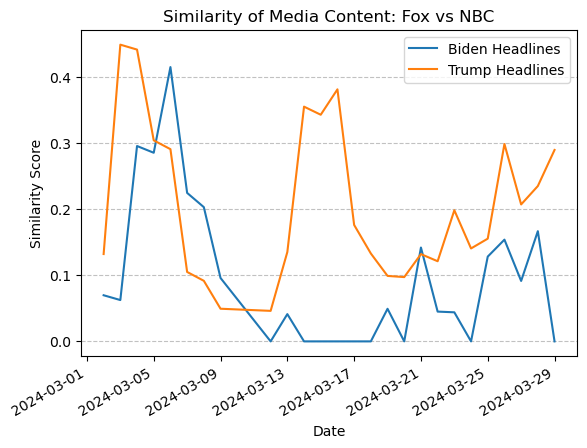

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
similarity_df.plot(ax=ax)
ax.set_ylabel('Similarity Score')
ax.set_title('Similarity of Media Content: Fox vs NBC')
ax.set_facecolor("#ffffff")
ax.grid(axis="y", which="major", color="#666666", linestyle='--', alpha=0.4)

plt.savefig('Similarity of Media Organisations.png')

In [167]:
adj_matrix_df = cnn_co_occurence.loc[top_cnn_words][top_cnn_words]
fox_adj_matrix_df = fox_co_occurence.loc[top_fox_words][top_fox_words]

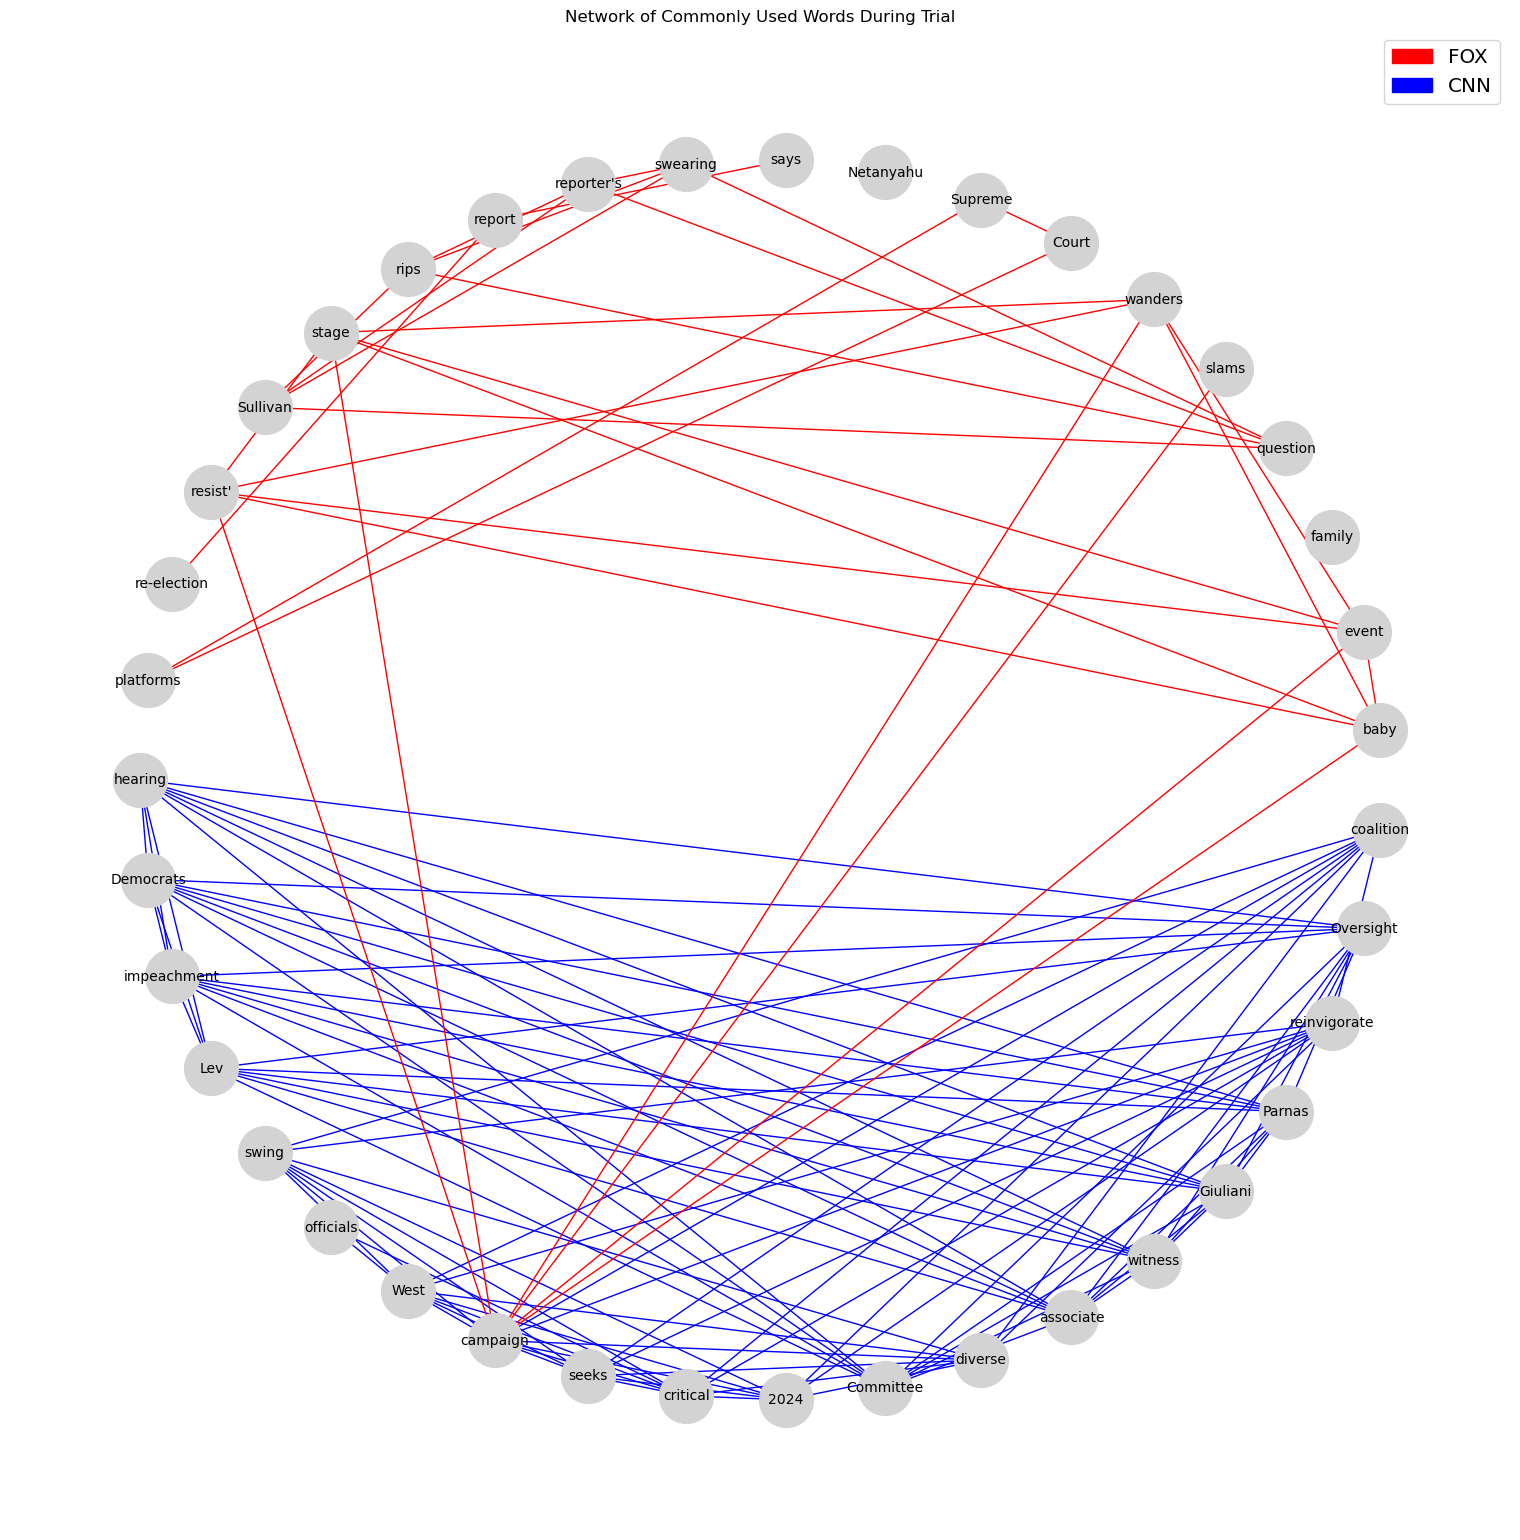

In [230]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

adj_matrix = adj_matrix_df.values
adj_matrix_fox = fox_adj_matrix_df.values


# Create an empty graph
G = nx.Graph()

existing_nodes = {}
num_nodes = 0
# Add nodes
for i in range(len(adj_matrix_df.columns)):
    G.add_node(i)
    existing_nodes[adj_matrix_df.columns[i]] = i
    num_nodes += 1

cnn_edges = []
# Add edges only where the connection is non-zero
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i][j] != 0:  # or any condition you want to check
            G.add_edge(i, j)
            cnn_edges.append((i, j))
            

# add in the fox nodes if they don't exist
fox_translations = {}
for i in range(num_nodes, num_nodes + len(fox_adj_matrix_df.columns)):
    if fox_adj_matrix_df.columns[i - num_nodes] not in existing_nodes:
        fox_translations[i - num_nodes] = i
        existing_nodes[fox_adj_matrix_df.columns[i - num_nodes]] = i
        G.add_node(i)
    else:
        fox_translations[i - num_nodes] = existing_nodes[fox_adj_matrix_df.columns[i - num_nodes]]

fox_edges = []
# add in the fox edgestranslations' 
for i in range(fox_adj_matrix_df.shape[0]):
    for j in range(fox_adj_matrix_df.shape[1]):
        
        if adj_matrix_fox[i][j] != 0:  # or any condition you want to check
            G.add_edge(fox_translations[i], fox_translations[j])
            fox_edges.append((fox_translations[i], fox_translations[j]))


# Create a mapping from index to column names
label_mapping = {key: value for value, key in existing_nodes.items()}
edge_colors = ['red' if edge in fox_edges else 'blue' for edge in G.edges()]
# Draw the graph


pos = nx.shell_layout(G)
plt.figure(figsize=(15,15))  # Increase figure size if needed
nx.draw(G, pos, labels=label_mapping, with_labels=True, node_color='lightgray', node_size=1500, font_size=10, edge_color=edge_colors)

# Create a patch (proxy artist) for every color
red_patch = mpatches.Patch(color='red', label='FOX')
blue_patch = mpatches.Patch(color='blue', label='CNN')

# Add legend
plt.legend(handles=[red_patch, blue_patch], fontsize='x-large')
plt.title("Network of Commonly Used Words During Trial")

plt.savefig('images/biden_sentiment_trial_graph.png', format='png')

In [191]:
existing_nodes
label_mapping = {key: value for value, key in existing_nodes.items()}
label_mapping

{0: 'hearing',
 1: 'Democrats',
 2: 'impeachment',
 3: 'Lev',
 4: 'swing',
 5: 'officials',
 6: 'West',
 7: 'campaign',
 8: 'seeks',
 9: 'critical',
 10: '2024',
 11: 'Committee',
 12: 'diverse',
 13: 'associate',
 14: 'witness',
 15: 'Giuliani',
 16: 'Parnas',
 17: 'reinvigorate',
 18: 'Oversight',
 19: 'coalition',
 21: 'baby',
 22: 'event',
 23: 'family',
 24: 'question',
 25: 'slams',
 26: 'wanders',
 27: 'Court',
 28: 'Supreme',
 29: 'Netanyahu',
 30: 'says',
 31: 'swearing',
 32: "reporter's",
 33: 'report',
 34: 'rips',
 35: 'stage',
 36: 'Sullivan',
 37: "resist'",
 38: 're-election',
 39: 'platforms'}

In [173]:
i

20

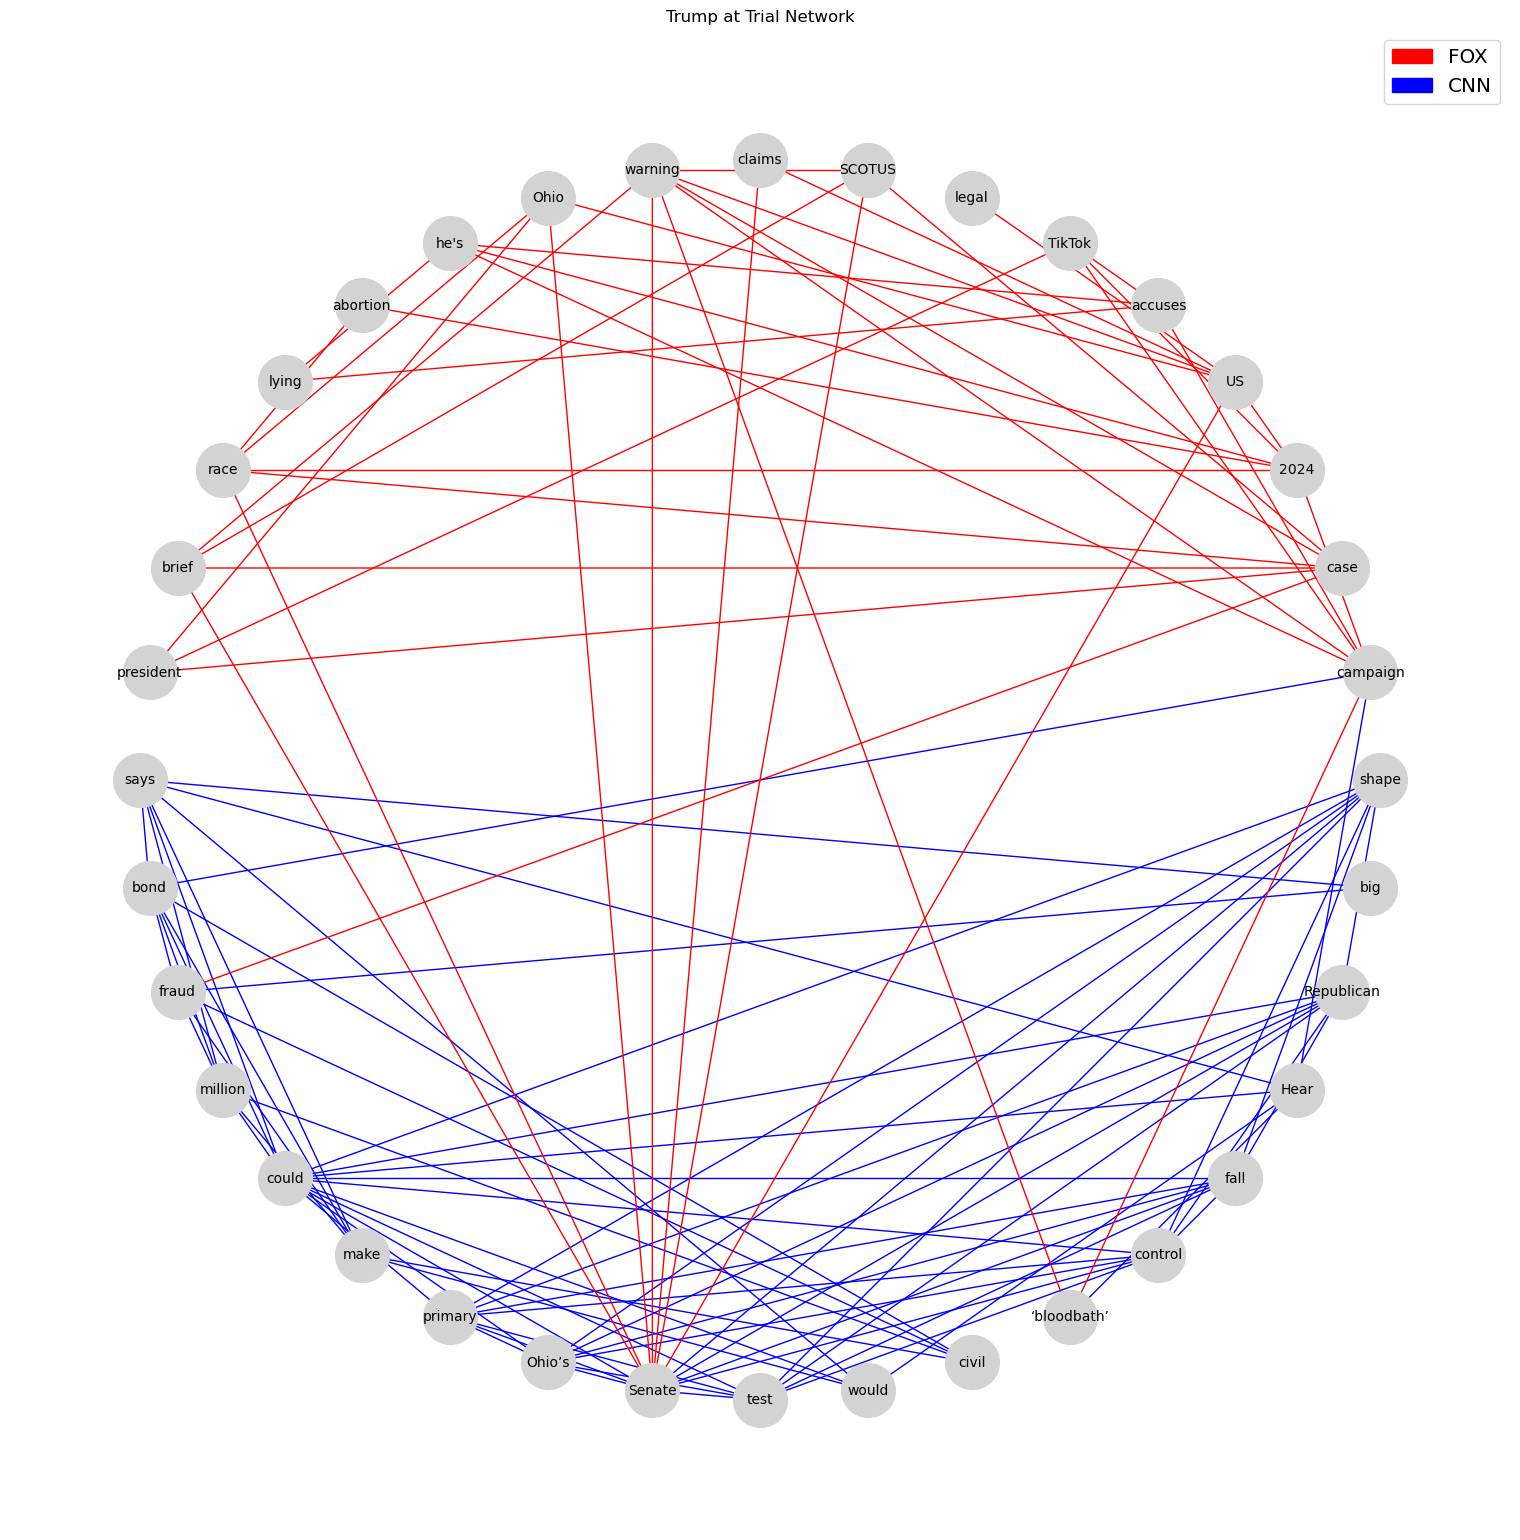

In [235]:


def create_and_save_network_graph(cnn_co: pd.DataFrame, fox_co: pd.DataFrame, politician: str, 
                                 plot_title='network_graph'):
    top_cnn_words = list(cnn_co.sort_values(politician, ascending=False).head(20).index)
    top_fox_words = list(fox_co.sort_values(politician, ascending=False).head(20).index)

    adj_matrix_df = cnn_co_occurence.loc[top_cnn_words][top_cnn_words]
    fox_adj_matrix_df = fox_co_occurence.loc[top_fox_words][top_fox_words]


    adj_matrix = adj_matrix_df.values
    adj_matrix_fox = fox_adj_matrix_df.values


    # Create an empty graph
    G = nx.Graph()

    existing_nodes = {}
    num_nodes = 0
    # Add nodes
    for i in range(len(adj_matrix_df.columns)):
        G.add_node(i)
        existing_nodes[adj_matrix_df.columns[i]] = i
        num_nodes += 1

    cnn_edges = []
    # Add edges only where the connection is non-zero
    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if adj_matrix[i][j] != 0:  # or any condition you want to check
                G.add_edge(i, j)
                cnn_edges.append((i, j))


    # add in the fox nodes if they don't exist
    fox_translations = {}
    for i in range(num_nodes, num_nodes + len(fox_adj_matrix_df.columns)):
        if fox_adj_matrix_df.columns[i - num_nodes] not in existing_nodes:
            fox_translations[i - num_nodes] = i
            existing_nodes[fox_adj_matrix_df.columns[i - num_nodes]] = i
            G.add_node(i)
        else:
            fox_translations[i - num_nodes] = existing_nodes[fox_adj_matrix_df.columns[i - num_nodes]]

    fox_edges = []
    # add in the fox edgestranslations' 
    for i in range(fox_adj_matrix_df.shape[0]):
        for j in range(fox_adj_matrix_df.shape[1]):

            if adj_matrix_fox[i][j] != 0:  # or any condition you want to check
                G.add_edge(fox_translations[i], fox_translations[j])
                fox_edges.append((fox_translations[i], fox_translations[j]))


    # Create a mapping from index to column names
    label_mapping = {key: value for value, key in existing_nodes.items()}
    edge_colors = ['red' if edge in fox_edges else 'blue' for edge in G.edges()]
    # Draw the graph


    pos = nx.shell_layout(G)
    plt.figure(figsize=(15,15))  # Increase figure size if needed
    nx.draw(G, pos, labels=label_mapping, with_labels=True, node_color='lightgray', node_size=1500, font_size=10, edge_color=edge_colors)

    # Create a patch (proxy artist) for every color
    red_patch = mpatches.Patch(color='red', label='FOX')
    blue_patch = mpatches.Patch(color='blue', label='CNN')

    # Add legend
    plt.legend(handles=[red_patch, blue_patch], fontsize='x-large')
    plt.title(f"{plot_title} Network")

    plt.savefig(f'images/{plot_title}.png', format='png')
    
    
create_and_save_network_graph(cnn_co, fox_co, 'Trump', 'Trump at Trial')

In [16]:
output = defaultdict(list)
current_date = start_date 
while current_date <= end_date:

    try: 

        for media_org in media_orgs:
            df = get_headline_df(media_org, current_date)

            num_political = len([1 for i in df['Headline'] if ('biden' in i.lower() or 'trump' in i.lower())])
            percentage= num_political/len(df)
            output[media_org].append(percentage)

        output['Date'].append(pd.to_datetime(current_date))
        current_date += datetime.timedelta(days=1)


    except:
        current_date += datetime.timedelta(days=1)
        continue


<Axes: xlabel='Date'>

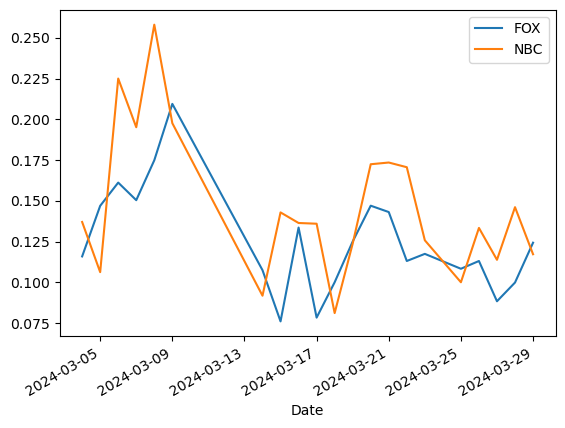

In [18]:
pd.DataFrame(output).set_index('Date').plot()